In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import math

In [5]:
d_model = 512
droput = 0.1
max_len = 60

In [9]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


input = torch.tensor([[1, 2, 4, 5], [4, 3, 2, 9]])
embedding = Embeddings(d_model, 1000)
output = embedding(input)
print(output.size())

pe = PositionalEncoding(d_model, droput, max_len)
pe_result = pe(output)
print(pe_result)
print(pe_result.size())

torch.Size([2, 4, 512])
tensor([[[-2.2185e+01,  3.7995e+01,  3.1803e+01,  ...,  6.4530e+00,
          -1.4493e+00, -6.0778e+00],
         [-1.1918e+01, -1.1833e+00,  3.0257e+01,  ...,  1.4894e+01,
          -1.5061e+01,  1.0968e+01],
         [ 9.7447e+00, -3.9981e+01,  5.1904e+00,  ...,  5.2472e-02,
           1.9687e+01,  1.3190e+01],
         [-0.0000e+00, -3.1976e+00, -1.6949e+01,  ...,  3.2291e+01,
           8.1057e+00, -4.7685e+01]],

        [[ 8.7343e+00, -3.8407e+01,  4.1499e+00,  ...,  5.2472e-02,
           1.9687e+01,  1.3190e+01],
         [-4.3045e+01,  6.2592e-01, -4.9020e-01,  ..., -2.4483e+01,
          -1.1220e+01,  2.0262e+00],
         [-1.1843e+01, -2.2460e+00,  3.0385e+01,  ...,  1.4894e+01,
          -1.5060e+01,  1.0968e+01],
         [ 1.0556e+01, -5.9169e+00,  2.0052e+00,  ...,  5.6421e+01,
           2.7014e+00, -4.1476e+01]]], grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


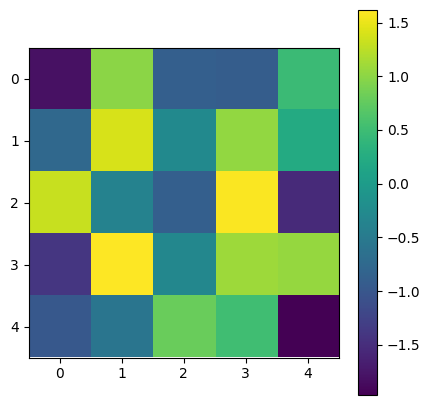

In [5]:
input = torch.randn(5, 5)
plt.figure(figsize=(5, 5))
plt.imshow(input)
plt.colorbar()
plt.show()

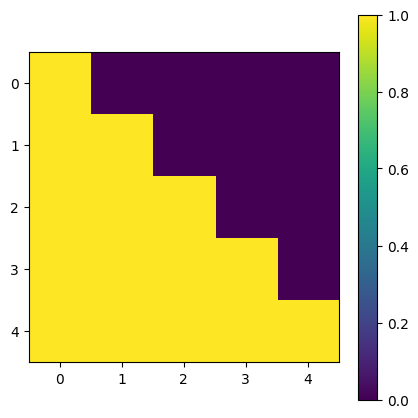

In [16]:
def subsequent_mask(sz):
    attn_shape = (1, sz, sz)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(1 - subsequent_mask)


seq_mask = subsequent_mask(5)
plt.figure(figsize=(5, 5))
plt.imshow(seq_mask[0])
plt.colorbar()
plt.show()

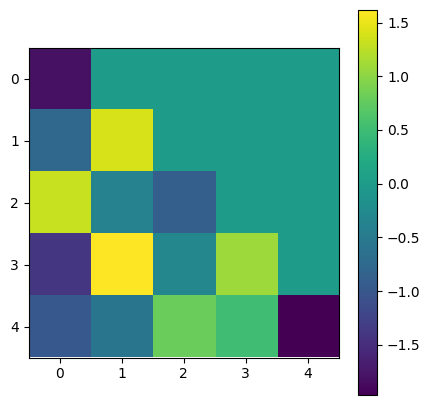

In [11]:
masked_input = input.masked_fill(seq_mask[0] == 0, 1e-9)
plt.figure(figsize=(5, 5))
plt.imshow(masked_input)
plt.colorbar()
plt.show()

In [21]:
def attention(q, k, v, mask=None, dropout=None):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_atten = torch.softmax(scores, dim=-1)
    if dropout is not None:
        p_atten = dropout(p_atten)
    return torch.matmul(p_atten, v), p_atten


query = key = value = pe_result
atten, p_atten = attention(query, key, value)

print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

atten: tensor([[[-2.2185e+01,  3.7995e+01,  3.1803e+01,  ...,  6.4530e+00,
          -1.4493e+00, -6.0778e+00],
         [-1.1918e+01, -1.1833e+00,  3.0257e+01,  ...,  1.4894e+01,
          -1.5061e+01,  1.0968e+01],
         [ 9.7447e+00, -3.9981e+01,  5.1904e+00,  ...,  5.2472e-02,
           1.9687e+01,  1.3190e+01],
         [ 0.0000e+00, -3.1976e+00, -1.6949e+01,  ...,  3.2291e+01,
           8.1057e+00, -4.7685e+01]],

        [[ 8.7343e+00, -3.8407e+01,  4.1499e+00,  ...,  5.2472e-02,
           1.9687e+01,  1.3190e+01],
         [-4.3045e+01,  6.2592e-01, -4.9020e-01,  ..., -2.4483e+01,
          -1.1220e+01,  2.0262e+00],
         [-1.1843e+01, -2.2460e+00,  3.0385e+01,  ...,  1.4894e+01,
          -1.5060e+01,  1.0968e+01],
         [ 1.0556e+01, -5.9169e+00,  2.0052e+00,  ...,  5.6421e+01,
           2.7014e+00, -4.1476e+01]]], grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],


In [22]:
mask = torch.zeros(4, 4)
atten, p_atten = attention(query, key, value, mask=mask)
print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

atten: tensor([[[ -6.0897,  -1.5917,  12.5755,  ...,  13.4226,   2.8208,  -7.4012],
         [ -6.0897,  -1.5917,  12.5755,  ...,  13.4226,   2.8208,  -7.4012],
         [ -6.0897,  -1.5917,  12.5755,  ...,  13.4226,   2.8208,  -7.4012],
         [ -6.0897,  -1.5917,  12.5755,  ...,  13.4226,   2.8208,  -7.4012]],

        [[ -8.8994, -11.4861,   9.0124,  ...,  11.7209,  -0.9730,  -3.8229],
         [ -8.8994, -11.4861,   9.0124,  ...,  11.7209,  -0.9730,  -3.8229],
         [ -8.8994, -11.4861,   9.0124,  ...,  11.7209,  -0.9730,  -3.8229],
         [ -8.8994, -11.4861,   9.0124,  ...,  11.7209,  -0.9730,  -3.8229]]],
       grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.250

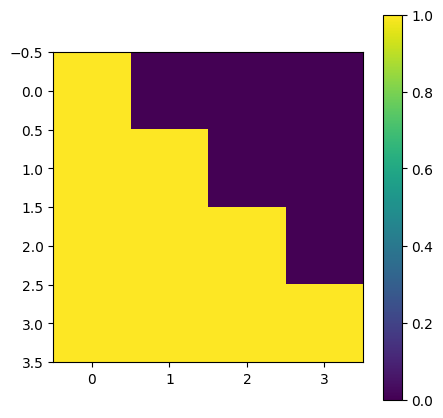

atten: tensor([[[-2.2185e+01,  3.7995e+01,  3.1803e+01,  ...,  6.4530e+00,
          -1.4493e+00, -6.0778e+00],
         [-1.1918e+01, -1.1833e+00,  3.0257e+01,  ...,  1.4894e+01,
          -1.5061e+01,  1.0968e+01],
         [ 9.7447e+00, -3.9981e+01,  5.1904e+00,  ...,  5.2472e-02,
           1.9687e+01,  1.3190e+01],
         [ 0.0000e+00, -3.1976e+00, -1.6949e+01,  ...,  3.2291e+01,
           8.1057e+00, -4.7685e+01]],

        [[ 8.7343e+00, -3.8407e+01,  4.1499e+00,  ...,  5.2472e-02,
           1.9687e+01,  1.3190e+01],
         [-4.3045e+01,  6.2592e-01, -4.9020e-01,  ..., -2.4483e+01,
          -1.1220e+01,  2.0262e+00],
         [-1.1843e+01, -2.2460e+00,  3.0385e+01,  ...,  1.4894e+01,
          -1.5060e+01,  1.0968e+01],
         [ 1.0556e+01, -5.9169e+00,  2.0052e+00,  ...,  5.6421e+01,
           2.7014e+00, -4.1476e+01]]], grad_fn=<UnsafeViewBackward0>)
p_atten: tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]],


In [24]:
mask = subsequent_mask(4)
plt.figure(figsize=(5, 5))
plt.imshow(mask[0])
plt.colorbar()
plt.show()

atten, p_atten = attention(query, key, value, mask=mask)
print(f"atten: {atten}")
print(f"p_atten: {p_atten}")

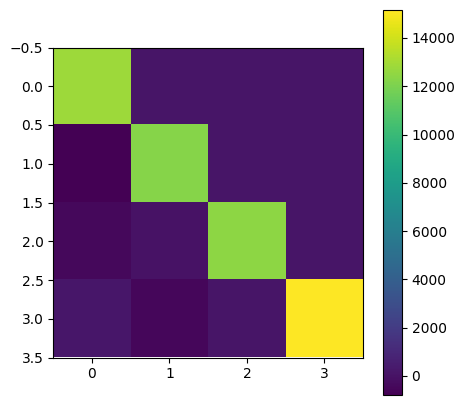